In [1]:
#1 imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris, load_digits, load_wine, fetch_olivetti_faces, make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, accuracy_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, MiniBatchKMeans, Birch, OPTICS
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from pyclustering.cluster.kmedoids import kmedoids
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
# from sklearn_extra.cluster import KMedoids
import hdbscan


# import warnings
# warnings.filterwarnings("ignore")


In [2]:
datasets = {
    "Iris": load_iris(return_X_y=True),
    "Digits": load_digits(return_X_y=True),
    "Wine": load_wine(return_X_y=True),
    "Synthetic Blobs": make_blobs(n_samples=500, centers=4, random_state=42, cluster_std=1.2),
    "Olivetti Faces (flattened)": fetch_olivetti_faces(return_X_y=True),
}


In [3]:
#4 
#Define kmedoids wrapper using pyclusteringq
def kmedoids_wrapper(data, k):
    try:
        from pyclustering.cluster.kmedoids import kmedoids
    except ImportError:
        raise ImportError("pyclustering is not installed. Please install it with 'pip install pyclustering'")

    initial_medoids = np.random.choice(len(data), k, replace=False)
    kmedoids_instance = kmedoids(data.tolist(), list(initial_medoids))
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    labels = np.empty(len(data), dtype=int)
    for cluster_id, cluster in enumerate(clusters):
        for idx in cluster:
            labels[idx] = cluster_id
    return labels

# Main clustering algorithm dictionary
clustering_algorithms = {
    "KMeans": lambda X: KMeans(n_clusters=4, random_state=42).fit_predict(X),
    "MiniBatchKMeans": lambda X: MiniBatchKMeans(n_clusters=4, random_state=42).fit_predict(X),
    "PyKMedoids": lambda X: kmedoids_wrapper(X, k=4),
    "Agglomerative": lambda X: AgglomerativeClustering(n_clusters=4).fit_predict(X),
    "Ward": lambda X: AgglomerativeClustering(n_clusters=4, linkage='ward').fit_predict(X),
    "BIRCH": lambda X: Birch(n_clusters=4).fit_predict(X),
    "DBSCAN": lambda X: DBSCAN(eps=1.5, min_samples=5).fit_predict(X),
    "OPTICS": lambda X: OPTICS(min_samples=5).fit_predict(X),
    "HDBSCAN": lambda X: hdbscan.HDBSCAN(min_cluster_size=10).fit_predict(X),
    "Spectral": lambda X: SpectralClustering(n_clusters=4, affinity="nearest_neighbors", n_neighbors=10, assign_labels="kmeans", random_state=42).fit_predict(X),
    "GMM": lambda X: GaussianMixture(n_components=4, random_state=42).fit(X).predict(X),
    "BGMM": lambda X: BayesianGaussianMixture(n_components=4, random_state=42).fit(X).predict(X),
}



In [4]:
#5
for dataset_name, (X, y_true) in datasets.items():
    print(f"\nProcessing {dataset_name}...")
    results = []

    # Standardize
    X_scaled = StandardScaler().fit_transform(X)

    for algo_name, algo_func in clustering_algorithms.items():
        try:
            if algo_name == "SeededKMeans":
                if len(np.unique(y_true)) != 4:
                    raise ValueError("SeededKMeans: true labels don't match expected clusters.")
                y_pred = algo_func(X_scaled, y_true)
            else:
                y_pred = algo_func(X_scaled)

            score_sil = silhouette_score(X_scaled, y_pred)
            score_ari = adjusted_rand_score(y_true, y_pred)
            score_nmi = normalized_mutual_info_score(y_true, y_pred)

            results.append((algo_name, score_sil, score_ari, score_nmi))

        except ImportError as e:
            print(f"Skipping {algo_name}: {e}")
        except AttributeError as e:
            print(f"Skipping {algo_name}: {e}")
        except ValueError as e:
            print(f"Skipping {algo_name}: {e}")
        except Exception as e:
            print(f"Skipping {algo_name} due to unexpected error: {e}")

    # Convert to DataFrame and display
    df = pd.DataFrame(results, columns=["Algorithm", "Silhouette", "ARI", "NMI"])
    display(df)



Processing Iris...


,Algorithm,Silhouette,ARI,NMI
0,KMeans,0.385045,0.494535,0.609423
1,MiniBatchKMeans,0.384255,0.514008,0.618329
2,PyKMedoids,0.394045,0.528014,0.619672
3,Agglomerative,0.400636,0.587941,0.663414
4,Ward,0.400636,0.587941,0.663414
5,BIRCH,0.404826,0.631395,0.692147
6,DBSCAN,0.581750,0.568116,0.733680
7,OPTICS,-0.300865,0.051416,0.292357
8,HDBSCAN,0.489118,0.539409,0.677795
9,Spectral,0.388799,0.539216,0.650875



Processing Digits...
Skipping DBSCAN: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)


,Algorithm,Silhouette,ARI,NMI
0,KMeans,0.106962,0.228051,0.411126
1,MiniBatchKMeans,0.082499,0.240816,0.417610
2,PyKMedoids,0.083253,0.240417,0.387749
3,Agglomerative,0.091627,0.282933,0.501215
4,Ward,0.091627,0.282933,0.501215
5,BIRCH,0.091627,0.282933,0.501215
6,OPTICS,-0.252096,0.003506,0.134290
7,HDBSCAN,0.166066,0.003396,0.034420
8,Spectral,0.055224,0.258056,0.583662
9,GMM,0.097980,0.214897,0.400035



Processing Wine...
Skipping DBSCAN: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)


,Algorithm,Silhouette,ARI,NMI
0,KMeans,0.254228,0.817179,0.798351
1,MiniBatchKMeans,0.285772,0.868589,0.859045
2,PyKMedoids,0.233387,0.720823,0.755927
3,Agglomerative,0.225837,0.656817,0.712784
4,Ward,0.225837,0.656817,0.712784
5,BIRCH,0.225837,0.656817,0.712784
6,OPTICS,-0.133640,0.035817,0.194946
7,HDBSCAN,0.054728,0.232853,0.343444
8,Spectral,0.227858,0.707672,0.744260
9,GMM,0.254228,0.817179,0.798351



Processing Synthetic Blobs...
Skipping DBSCAN: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)


C:\Users\harsh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


,Algorithm,Silhouette,ARI,NMI
0,KMeans,0.755747,1.000000,1.000000
1,MiniBatchKMeans,0.755747,1.000000,1.000000
2,PyKMedoids,0.755747,1.000000,1.000000
3,Agglomerative,0.754934,0.994656,0.991591
4,Ward,0.754934,0.994656,0.991591
5,BIRCH,0.754077,0.989355,0.985183
6,OPTICS,-0.338708,0.022621,0.327190
7,HDBSCAN,0.706667,0.997335,0.995816
8,Spectral,0.453855,0.731299,0.837109
9,GMM,0.755747,1.000000,1.000000



Processing Olivetti Faces (flattened)...
Skipping DBSCAN: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Skipping HDBSCAN: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)


,Algorithm,Silhouette,ARI,NMI
0,KMeans,0.097504,0.059793,0.327692
1,MiniBatchKMeans,0.100789,0.056126,0.339483
2,PyKMedoids,0.096257,0.048723,0.294844
3,Agglomerative,0.086093,0.067402,0.383313
4,Ward,0.086093,0.067402,0.383313
5,BIRCH,0.086093,0.067402,0.383313
6,OPTICS,-0.049179,0.048749,0.563337
7,Spectral,0.024674,0.014245,0.241029
8,GMM,0.097504,0.059793,0.327692
9,BGMM,0.097504,0.059793,0.327692


In [5]:
def compute_explainability_metrics(X, cluster_labels):
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.model_selection import train_test_split
    import numpy as np

    # Filter out noise (label = -1, like in DBSCAN)
    mask = cluster_labels != -1
    if mask.sum() == 0:
        # Return Nones or NaNs if no points are clustered
        return np.nan, np.nan, np.nan, np.nan

    X_masked = X[mask]
    y_masked = cluster_labels[mask]
    coverage = np.round(mask.sum() / len(cluster_labels), 2)

    # Now safe to split
    X_train, X_test, y_train, y_test = train_test_split(
        X_masked, y_masked, test_size=0.3, random_state=42
    )

    # Train surrogate model
    tree = DecisionTreeClassifier(max_depth=5, random_state=42)
    tree.fit(X_train, y_train)
    fidelity = np.round(tree.score(X_test, y_test), 2)

    # Comprehensibility = inverse of tree depth
    comp = np.round(1 / (tree.get_depth() + 1), 2)

    # Stability: retrain tree and measure prediction consistency
    tree2 = DecisionTreeClassifier(max_depth=5, random_state=24)
    tree2.fit(X_train, y_train)
    stab = np.round(np.mean(tree.predict(X_test) == tree2.predict(X_test)), 2)

    return coverage, fidelity, comp, stab



In [7]:
# Store results
results = []

for dname, (X, _) in datasets.items():
    X_scaled = StandardScaler().fit_transform(X)
    for cname, cluster_fn in clustering_algorithms.items():
        labels = cluster_fn(X_scaled)
        cov, fid, comp, stab = compute_explainability_metrics(X_scaled, labels)
        results.append([dname, cname, cov, fid, comp, stab])

# Present as DataFrame
df_results = pd.DataFrame(results, columns=["Dataset", "Algorithm", "Coverage", "Fidelity", "Comprehensibility", "Stability"])
print(df_results)


C:\Users\harsh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


                       Dataset        Algorithm  Coverage  Fidelity  \
0                         Iris           KMeans      1.00      0.91   
1                         Iris  MiniBatchKMeans      1.00      0.89   
2                         Iris       PyKMedoids      1.00      0.89   
3                         Iris    Agglomerative      1.00      0.91   
4                         Iris             Ward      1.00      0.91   
5                         Iris            BIRCH      1.00      0.89   
6                         Iris           DBSCAN      1.00      1.00   
7                         Iris           OPTICS      0.27      1.00   
8                         Iris          HDBSCAN      0.99      1.00   
9                         Iris         Spectral      1.00      0.89   
10                        Iris              GMM      1.00      0.91   
11                        Iris             BGMM      1.00      0.96   
12                      Digits           KMeans      1.00      0.87   
13    

In [8]:
df_results

,Dataset,Algorithm,Coverage,Fidelity,Comprehensibility,Stability
0,Iris,KMeans,1.00,0.91,0.17,1.00
1,Iris,MiniBatchKMeans,1.00,0.89,0.17,1.00
2,Iris,PyKMedoids,1.00,0.89,0.17,1.00
3,Iris,Agglomerative,1.00,0.91,0.17,0.93
4,Iris,Ward,1.00,0.91,0.17,0.93
5,Iris,BIRCH,1.00,0.89,0.17,1.00
6,Iris,DBSCAN,1.00,1.00,0.50,1.00
7,Iris,OPTICS,0.27,1.00,0.25,1.00
8,Iris,HDBSCAN,0.99,1.00,0.33,1.00
9,Iris,Spectral,1.00,0.89,0.17,0.96


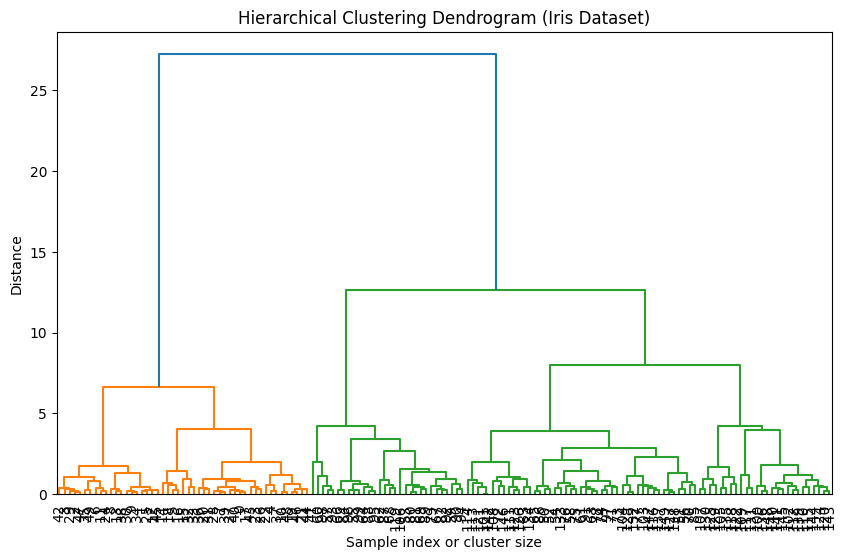

In [9]:
# for visualizations
#dendogram


# Load and scale data
iris = load_iris()
X = StandardScaler().fit_transform(iris.data)

# Linkage matrix for dendrogram
Z = linkage(X, method='ward')

# Plot dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z, truncate_mode='lastp', p=150, leaf_rotation=90., leaf_font_size=10.)
plt.title("Hierarchical Clustering Dendrogram (Iris Dataset)")
plt.xlabel("Sample index or cluster size")
plt.ylabel("Distance")
plt.show()


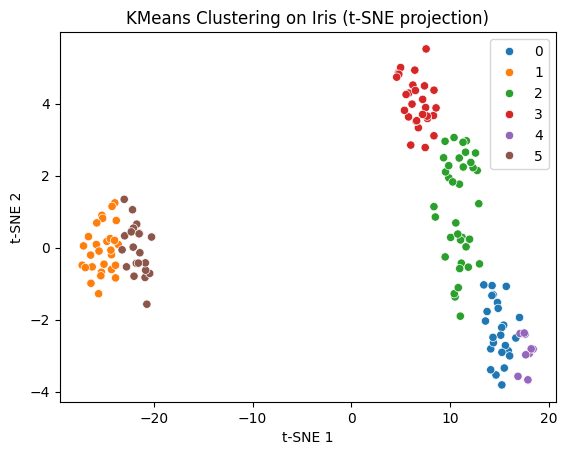

In [10]:

# for t-SNE
# Load Iris
# iris = load_iris()
# X = StandardScaler().fit_transform(iris.data)
iris = load_iris()
X = iris.data           # features (150 samples × 4 features)
y_true = iris.target    # actual labels (for reference only)


# KMeans
kmeans = KMeans(n_clusters=6).fit(X)
labels = kmeans.labels_  # assigned labels for every point

# kmeans = KMeans(n_clusters=6, random_state=42)
# labels = kmeans.fit_predict(X)

# t-SNE for visualization
X_embedded = TSNE(n_components=2, random_state=42).fit_transform(X)

# Plot
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=labels, palette="tab10")
plt.title("KMeans Clustering on Iris (t-SNE projection)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()


KMeans: 3 clusters found.
GMM: 3 clusters found.
DBSCAN: 0 clusters found.
Agglomerative: 3 clusters found.


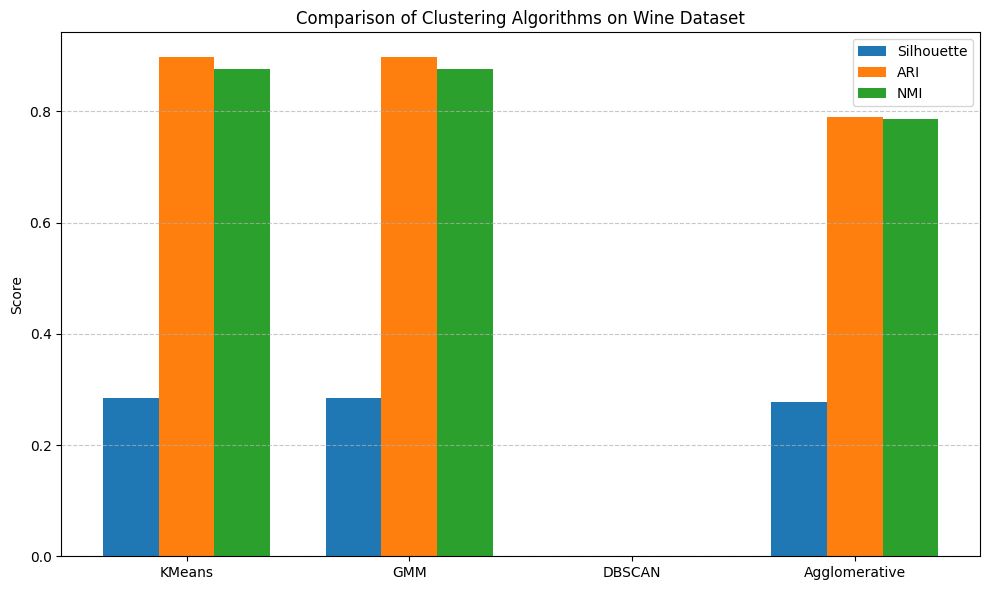

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

# Add Agglomerative Clustering to models

# Load and scale the data
data = load_wine()
X = StandardScaler().fit_transform(data.data)
y_true = data.target

# Initialize algorithms
models = {
    'KMeans': KMeans(n_clusters=3, random_state=42),
    'GMM': GaussianMixture(n_components=3, random_state=42),
    'DBSCAN': DBSCAN(eps=0.6, min_samples=5),
    'Agglomerative' : AgglomerativeClustering(n_clusters=3)# tuned for wine dataset
}

# Store metrics
results = {
    'Algorithm': [],
    'Silhouette': [],
    'ARI': [],
    'NMI': []
}

# Compute scores
for name, model in models.items():
    if name == 'GMM':
        labels = model.fit(X).predict(X)
    else:
        labels = model.fit_predict(X)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"{name}: {n_clusters} clusters found.")

    if n_clusters > 1:
        silhouette = silhouette_score(X, labels)
        ari = adjusted_rand_score(y_true, labels)
        nmi = normalized_mutual_info_score(y_true, labels)
    else:
        silhouette, ari, nmi = np.nan, np.nan, np.nan

    results['Algorithm'].append(name)
    results['Silhouette'].append(silhouette)
    results['ARI'].append(ari)
    results['NMI'].append(nmi)

# Bar chart
metrics = ['Silhouette', 'ARI', 'NMI']
x = np.arange(len(results['Algorithm']))
width = 0.25

plt.figure(figsize=(10, 6))
for i, metric in enumerate(metrics):
    plt.bar(x + i * width,
            [results[metric][j] for j in range(len(x))],
            width,
            label=metric)

plt.xticks(x + width, results['Algorithm'])
plt.ylabel("Score")
plt.title("Comparison of Clustering Algorithms on Wine Dataset")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


C:\Users\harsh\AppData\Local\Temp\ipykernel_10680\819846867.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  numeric_heatmap = heatmap_data.replace(algorithm_palette)


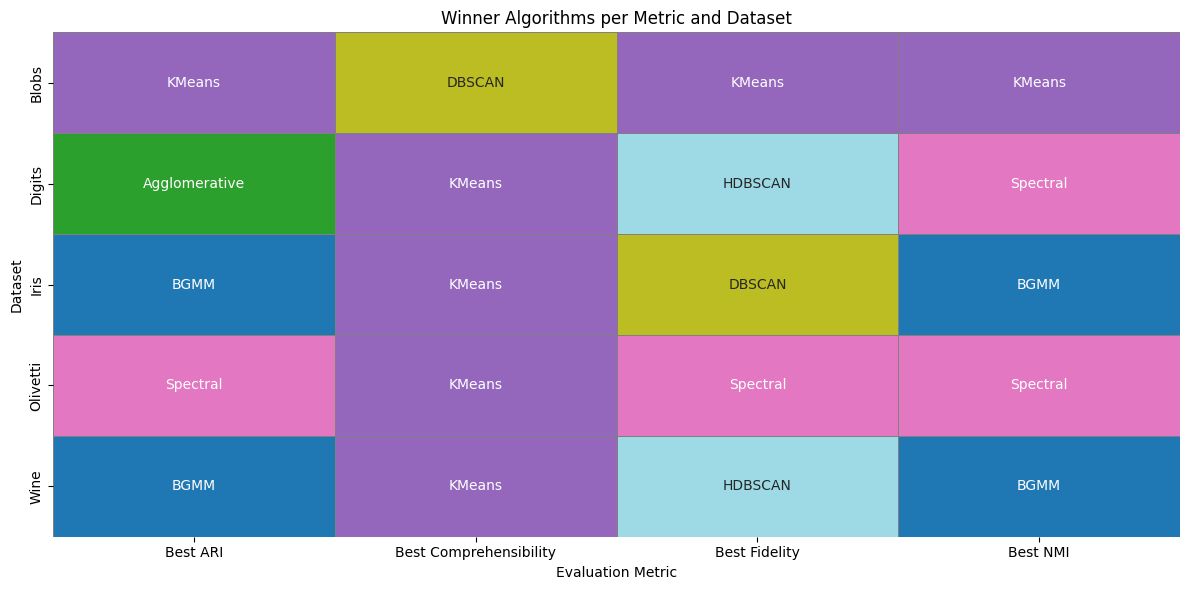

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Simulated data of "winning" algorithms per metric across datasets
# You can replace these with actual winners from your experiment
data = {
    'Dataset': ['Iris', 'Digits', 'Wine', 'Blobs', 'Olivetti'],
    # 'Best Silhouette': ['DBSCAN', 'HDBSCAN', 'BGMM', 'KMeans', 'MiniBatchKMeans'],
    'Best ARI': ['BGMM', 'Agglomerative', 'BGMM', 'KMeans', 'Spectral'],
    'Best NMI': ['BGMM', 'Spectral', 'BGMM', 'KMeans', 'Spectral'],
    'Best Fidelity': ['DBSCAN', 'HDBSCAN', 'HDBSCAN', 'KMeans', 'Spectral'],
    'Best Comprehensibility': ['KMeans', 'KMeans', 'KMeans', 'DBSCAN', 'KMeans']
}

df = pd.DataFrame(data)

# Convert from wide to long for heatmap plotting
df_long = df.melt(id_vars='Dataset', var_name='Metric', value_name='Best Algorithm')

# Create a pivot table for heatmap
heatmap_data = df_long.pivot(index='Dataset', columns='Metric', values='Best Algorithm')

# Map algorithms to integers for color coding
algorithm_palette = {
    alg: idx for idx, alg in enumerate(df_long['Best Algorithm'].unique())
}
numeric_heatmap = heatmap_data.replace(algorithm_palette)

# Reverse mapping for legend
inv_map = {v: k for k, v in algorithm_palette.items()}

# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(numeric_heatmap, annot=heatmap_data, fmt='', cmap='tab20', cbar=False,
            linewidths=0.5, linecolor='gray')
plt.title('Winner Algorithms per Metric and Dataset')
plt.xlabel('Evaluation Metric')
plt.ylabel('Dataset')
plt.tight_layout()
plt.show()


C:\Users\harsh\AppData\Local\Temp\ipykernel_10680\2253385164.py:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heatmap_numeric = heatmap_data.replace(algo_to_num)


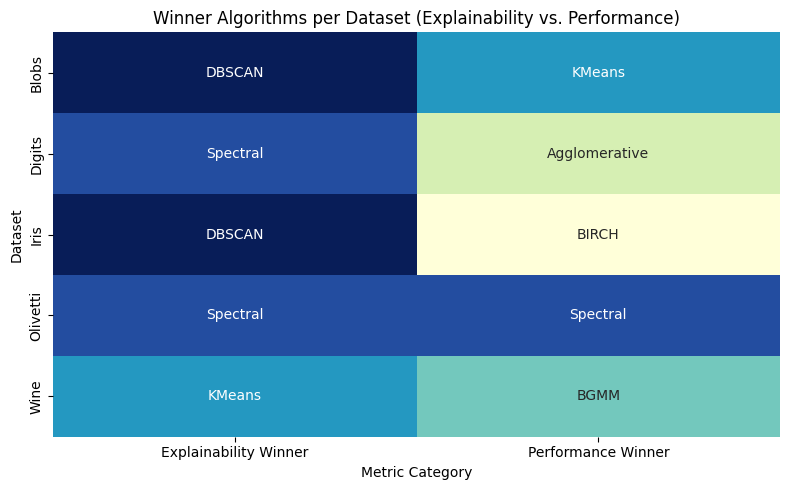

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Simulated best performer per dataset for both performance and explainability metrics
data = {
    'Dataset': ['Iris', 'Digits', 'Wine', 'Blobs', 'Olivetti'],
    'Performance Winner': ['BIRCH', 'Agglomerative', 'BGMM', 'KMeans', 'Spectral'],
    'Explainability Winner': ['DBSCAN', 'Spectral', 'KMeans', 'DBSCAN', 'Spectral']
}

df = pd.DataFrame(data)

# Melt for heatmap
df_melted = df.melt(id_vars='Dataset', var_name='Category', value_name='Algorithm')

# Create a pivot table for the heatmap
heatmap_data = df_melted.pivot(index='Dataset', columns='Category', values='Algorithm')

# Map algorithm names to numerical values for coloring
unique_algos = pd.unique(df_melted['Algorithm'])
algo_to_num = {algo: i for i, algo in enumerate(unique_algos)}
heatmap_numeric = heatmap_data.replace(algo_to_num)

# Plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_numeric, annot=heatmap_data, fmt='', cmap="YlGnBu", cbar=False)
plt.title("Winner Algorithms per Dataset (Explainability vs. Performance)")
plt.ylabel("Dataset")
plt.xlabel("Metric Category")
plt.tight_layout()
plt.show()
